Imports

In [1]:
import jax
import jax.numpy as jnp

import blackjax

import numpy as np

import matplotlib.pyplot as plt

Set seed

In [2]:
key = jax. random.PRNGKey(548)

Definine MH-Adjusted Microcanonical Markov Chain Monte Carlo

See: https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#adjusted-mclmc

In [5]:
from blackjax.mcmc.adjusted_mclmc_dynamic import rescale
from blackjax.util import run_inference_algorithm

def run_adjusted_mclmc_dynamic(
    logdensity_fn,
    num_steps,
    initial_position,
    key,
    transform=lambda state, _ : state.position,
    diagonal_preconditioning=True,
    random_trajectory_length=True,
    L_proposal_factor=jnp.inf
):

    init_key, tune_key, run_key = jax.random.split(key, 3)

    initial_state = blackjax.mcmc.adjusted_mclmc_dynamic.init(
        position=initial_position,
        logdensity_fn=logdensity_fn,
        random_generator_arg=init_key,
    )

    if random_trajectory_length:
        integration_steps_fn = lambda avg_num_integration_steps: lambda k: jnp.ceil(
            jax.random.uniform(k) * rescale(avg_num_integration_steps))
    else:
        integration_steps_fn = lambda avg_num_integration_steps: lambda _: jnp.ceil(avg_num_integration_steps)

    kernel = lambda rng_key, state, avg_num_integration_steps, step_size, inverse_mass_matrix: blackjax.mcmc.adjusted_mclmc_dynamic.build_kernel(
        integration_steps_fn=integration_steps_fn(avg_num_integration_steps),
        inverse_mass_matrix=inverse_mass_matrix,
    )(
        rng_key=rng_key,
        state=state,
        step_size=step_size,
        logdensity_fn=logdensity_fn,
        L_proposal_factor=L_proposal_factor,
    )

    target_acc_rate = 0.9 # our recommendation

    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.adjusted_mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        target=target_acc_rate,
        frac_tune1=0.1,
        frac_tune2=0.1,
        frac_tune3=0.1, # our recommendation
        diagonal_preconditioning=diagonal_preconditioning,
    )

    step_size = blackjax_mclmc_sampler_params.step_size
    L = blackjax_mclmc_sampler_params.L

    alg = blackjax.adjusted_mclmc_dynamic(
        logdensity_fn=logdensity_fn,
        step_size=step_size,
        integration_steps_fn=lambda key: jnp.ceil(
            jax.random.uniform(key) * rescale(L / step_size)
        ),
        inverse_mass_matrix=blackjax_mclmc_sampler_params.inverse_mass_matrix,
        L_proposal_factor=L_proposal_factor,
    )

    _, out = run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=False,
    )

    return out

Text(0.5, 1.0, 'Scatter Plot of Samples')

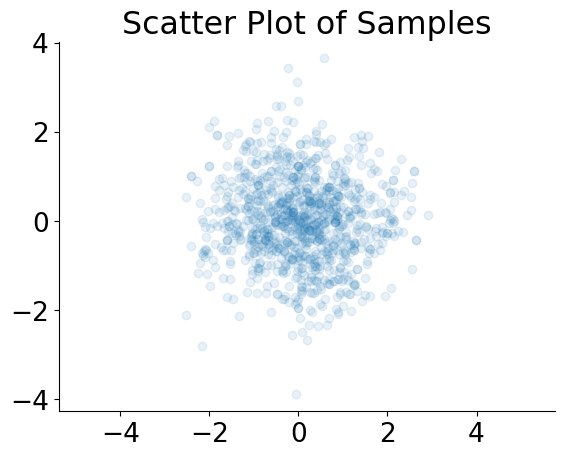

In [8]:
import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 19

import jax
import blackjax
import numpy as np
import jax.numpy as jnp
from datetime import date
import numpyro
import numpyro.distributions as dist

from numpyro.infer.util import initialize_model

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

# run the algorithm on a high dimensional gaussian, and show two of the dimensions

sample_key, rng_key = jax.random.split(rng_key)
samples = run_adjusted_mclmc_dynamic(
    logdensity_fn=lambda x: -0.5 * jnp.sum(jnp.square(x)),
    num_steps=1000,
    initial_position=jnp.ones((1000,)),
    key=sample_key,
)
plt.scatter(x=samples[:, 0], y=samples[:, 1], alpha=0.1)
plt.axis("equal")
plt.title("Scatter Plot of Samples")

Use NUTS

See: https://github.com/blackjax-devs/blackjax

In [9]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import numpy as np

import blackjax

observed = np.random.normal(10, 20, size=1_000)
def logdensity_fn(x):
    logpdf = stats.norm.logpdf(observed, x["loc"], x["scale"])
    return jnp.sum(logpdf)

# Build the kernel
step_size = 1e-3
inverse_mass_matrix = jnp.array([1., 1.])
nuts = blackjax.nuts(logdensity_fn, step_size, inverse_mass_matrix)

# Initialize the state
initial_position = {"loc": 1., "scale": 2.}
state = nuts.init(initial_position)

# Iterate
rng_key = jax.random.key(0)
step = jax.jit(nuts.step)
for i in range(100):
    nuts_key = jax.random.fold_in(rng_key, i)
    state, _ = step(nuts_key, state)